In [1]:
import numpy as np
import matplotlib as mpl
mpl.use("Agg")
from matplotlib import rc
rc('font',**{'family':'serif'})
rc('text', usetex=True)
from matplotlib import pyplot as plt
%matplotlib notebook

In [2]:
BENCHMARKS_DIR = 'bifrost/test/benchmarks/'
SERIAL_BENCHMARKS_DIR = BENCHMARKS_DIR + 'performance_vs_serial/'

In [3]:
ben_benchmarks = np.genfromtxt(
    SERIAL_BENCHMARKS_DIR + 'benchmarks_ben.log.txt',
    dtype=np.float32,
    delimiter=',');
additional_ben_benchmarks =  np.genfromtxt(
    SERIAL_BENCHMARKS_DIR + 'benchmarks_ben2.log.txt',
    dtype=np.float32,
    delimiter=',');
ben_benchmarks = np.concatenate((ben_benchmarks, additional_ben_benchmarks))

In [4]:
# size multiplier, gulp size, speedup
one_fft_benchmarks = ben_benchmarks[ben_benchmarks[:, 0] == 1.0][:, 1:]
two_fft_benchmarks = ben_benchmarks[ben_benchmarks[:, 0] == 2.0][:, 1:]

# Sort these based on the first column:

In [5]:
one_fft_benchmarks = one_fft_benchmarks[np.argsort(one_fft_benchmarks[:, 0])];
two_fft_benchmarks = two_fft_benchmarks[np.argsort(two_fft_benchmarks[:, 0])];

# Log 2 the first two columns for easy display in imshow:

In [6]:
one_log_fft_benchmarks = np.copy(one_fft_benchmarks)
two_log_fft_benchmarks = np.copy(two_fft_benchmarks)
one_log_fft_benchmarks[:, 0] = np.log2(one_fft_benchmarks[:, 0])
one_log_fft_benchmarks[:, 1] = np.log2(one_fft_benchmarks[:, 1]/32768)
two_log_fft_benchmarks[:, 0] = np.log2(two_fft_benchmarks[:, 0])
two_log_fft_benchmarks[:, 1] = np.log2(two_fft_benchmarks[:, 1]/32768)

In [7]:
one_fft_display_plot = np.zeros((
    int(np.max(one_log_fft_benchmarks[:, 1]) + 1),
    int(np.max(one_log_fft_benchmarks[:, 0] - 1) + 1)))
#file size multiplier
horiz_indices = one_log_fft_benchmarks[:, 0].astype(np.int) - 1
#gulp size multiplier
vert_indices = one_log_fft_benchmarks[:, 1].astype(np.int)
one_fft_display_plot[vert_indices, horiz_indices] = one_log_fft_benchmarks[:, 2]

# Chop off some rows
one_fft_display_plot = np.copy(one_fft_display_plot[:-3, :])

<IPython.core.display.Javascript object>


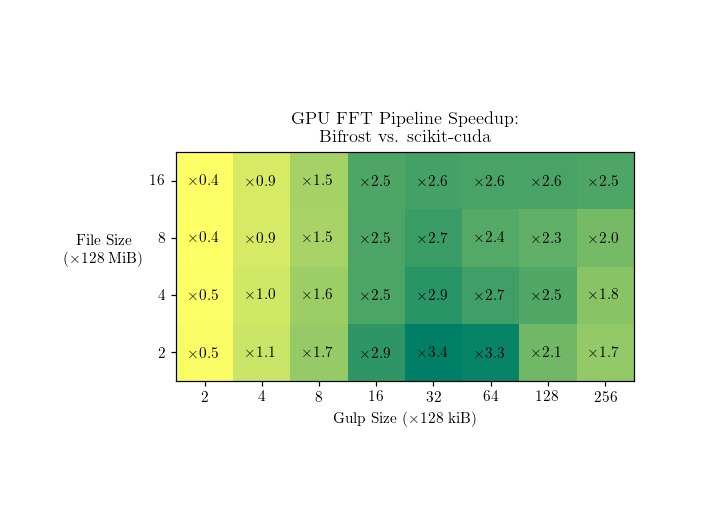

In [10]:
%matplotlib notebook
fig, ax1 = plt.subplots(1,1)
ax1.imshow(one_fft_display_plot.T, cmap='summer_r', origin='lower')
ax1.set_title(r'GPU FFT Pipeline Speedup:''\nBifrost vs. scikit-cuda')
ax1.set_xticklabels(['', 2, 4, 8, 16, 32, 64, 128, 256])
ax1.set_xlabel(r'Gulp Size ($\times$128 kiB)')
ax1.set_yticks([0, 1, 2, 3])
ax1.set_yticklabels([2, 4, 8, 16])
ax1.set_ylabel('File Size\n'r'($\times$128 MiB)',rotation=0, labelpad=30)
for (j,i),label in np.ndenumerate(one_fft_display_plot.T):
    ax1.text(i, j, r'$\times$%.1f'%label, ha='center', va='center')

fig.subplots_adjust(left=0.25)
fig.savefig('speedup.pdf', bbox_inches='tight')

In [9]:
two_fft_display_plot = np.zeros((
    int(np.max(two_log_fft_benchmarks[:, 1]) + 1),
    int(np.max(two_log_fft_benchmarks[:, 0] - 1) + 1)))
#file size multiplier
horiz_indices = two_log_fft_benchmarks[:, 0].astype(np.int)-1
#gulp size multiplier
vert_indices = two_log_fft_benchmarks[:, 1].astype(np.int)
two_fft_display_plot[vert_indices, horiz_indices] = two_log_fft_benchmarks[:, 2]

#chop off some rows
two_fft_display_plot = np.copy(two_fft_display_plot[2:-3, :])

<IPython.core.display.Javascript object>


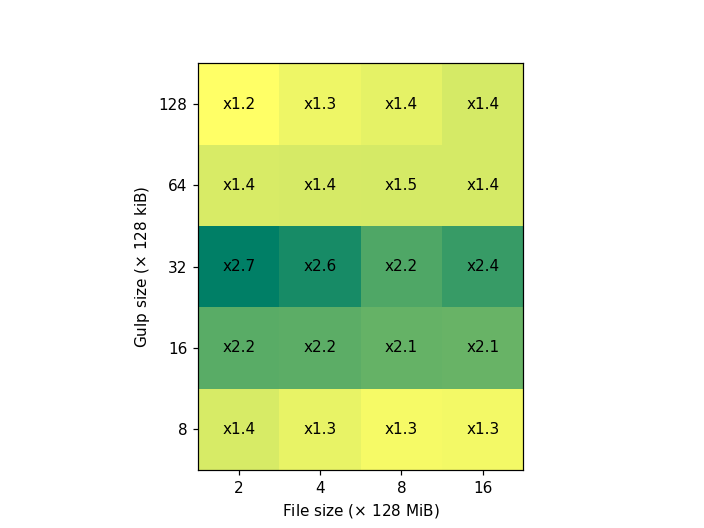

In [10]:
%matplotlib notebook
fig, ax1 = plt.subplots(1,1)
ax1.imshow(two_fft_display_plot, cmap='summer_r', origin='lower')
ax1.set_yticklabels(['', 8, 16, 32, 64, 128, 256])
ax1.set_ylabel(r'Gulp size ($\times$ 128 kiB)')
ax1.set_xticklabels(['', 2, 4, 8, 16])
ax1.set_xlabel(r'File size ($\times$ 128 MiB)')
for (j,i),label in np.ndenumerate(two_fft_display_plot):
    ax1.text(i, j, 'x%.1f'%label, ha='center', va='center')

# Caption ideas

Should emphasize:
- This pipeline was not tuned in any way, it is vanilla Bifrost code, with no core bindings set, and no block fusion enabled.
- Not only do you get more speed for same effort, but you get greater functionality for same effort (bf.map!)
- Easy to switch it to a real-time pipeline for a telescope
- These plots aren't meant to show anything particular about when Bifrost is useful and when it isn't, they are supposed to show the trend of where Bifrost becomes very effective: large gulp sizes and large amounts of data.
- Bottom slower for Bifrost because of the greater Python overhead incurred from small gulp sizes. Small effort tuning gulp sizes eliminates this.
- Both pipelines are GPU-based FFT pipelines, controlled in Python. Similar (say exactly) source lines of code. Through pipeline-parallelism, Bifrost achieves a speedup using the same underlying cuFFT functionality.
- Emphasize that a hand-tuned C or C++ pipeline compiled with optimization can be faster than Bifrost. However, due to the development effort associated with writing a stream-processing pipeline by hand, Bifrost is a competitive alternative.